Load stardist and utilities

In [1]:
from stardist.models import StarDist2D
import matplotlib.pyplot as plt
from csbdeep.utils import normalize
from stardist.plot import render_label
import numpy as np
import tifffile

## Data

StarDist does not provide any tools for opening images on its own.

Instead, this environment (when loaded from the provided YAML) includes packages for handling image loading including pillow, opencv, and tifffile. 

For the purpose of this example, we have opted to use tifffile.

In [2]:
image = tifffile.imread('MAX_registered time points-1.tif')
image.shape

(98, 2, 368, 341)

In this case, the image in the shape [T,C,Y,X] which includes a time component. As StarDist only expects 3 dimensions, we can index into just 1 time frame to use the pretrained models.

In [3]:
image_at_time = image[61]
image_at_time.shape

(2, 368, 341)

## Example Image

Now that we have formatted the image correctly, we can take a look at the channels to analyze

Text(0.5, 1.0, 'Cells')

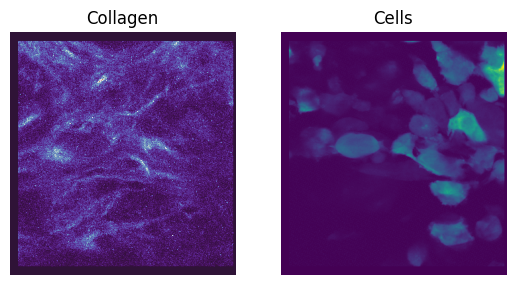

In [6]:
plt.subplot(1,2,1)
plt.imshow(image_at_time[0], cmap='twilight_shifted')
plt.axis('off')
plt.title(f'Collagen')

plt.subplot(1,2,2)
plt.imshow(image_at_time[1])
plt.axis('off')
plt.title(f'Cells')

## Pick from 3 StarDist2D models

Based on the kind of data being worked with and number of channels in each image

For 2D single channel images taken with Fluorescence (nuclear marker):
- 2D_versatile_fluo
- 2D_paper_dsb2018

For 2D RGB images taken with Brightfield (H&E)
- 2D_versatile_he


StarDist does have 3D capability as well that are not explored in this notebook but can be examined [here](https://github.com/stardist/stardist/tree/master/examples/3D)

In [7]:
def load_all_stardist():
    models = {
        'he' : StarDist2D.from_pretrained('2D_versatile_he'),
        'fluo': StarDist2D.from_pretrained('2D_versatile_fluo'),
        'dsb': StarDist2D.from_pretrained('2D_paper_dsb2018')   
    }

    return models

## Make a prediction using one of the models


In [8]:
all_stardist = load_all_stardist()

Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.
Found model '2D_versatile_fluo' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.479071, nms_thresh=0.3.
Found model '2D_paper_dsb2018' for 'StarDist2D'.
Loading network weights from 'weights_last.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.417819, nms_thresh=0.5.


Choose one model to use, in this case the fluorescence model.

In [9]:
model = all_stardist['fluo']

### Normalize data

Before predicting, make sure to normalize data as the StarDist models require it.

Predicting will return two things, 
- labels: the label instance image
- details: a dict of useful information

coord: <class 'numpy.ndarray'>
points: <class 'numpy.ndarray'>
prob: <class 'numpy.ndarray'>


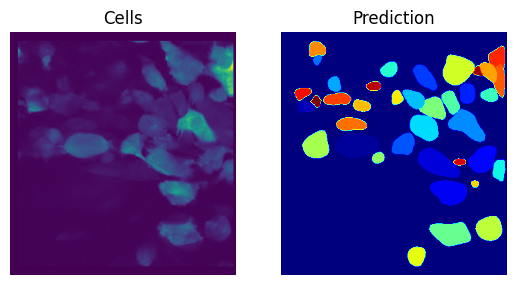

In [15]:
labels, details = model.predict_instances(normalize(image_at_time[1]))

plt.subplot(1,2,1)
plt.imshow(image_at_time[1])
plt.axis('off')
plt.title('Cells')

plt.subplot(1,2,2)
plt.imshow(labels, cmap='jet')
plt.axis('off')
plt.title('Prediction')

for k, v in details.items():
    print(f'{k}: {type(v)}')

## Test all models on image

One useful feature that StarDist provides is the automatic overlaying of labels over the original image with the `render_lable(labels, image)` function.

In [17]:
def display_stardist(img, model):
    img = normalize(img)
    labels, _ = model.predict_instances(img)

    plt.subplot(1,2,1)
    plt.imshow(img)
    plt.axis("off")
    plt.title("input image")

    plt.subplot(1,2,2)
    plt.imshow(render_label(labels, img=img))
    plt.axis("off")
    plt.title("prediction + input overlay")

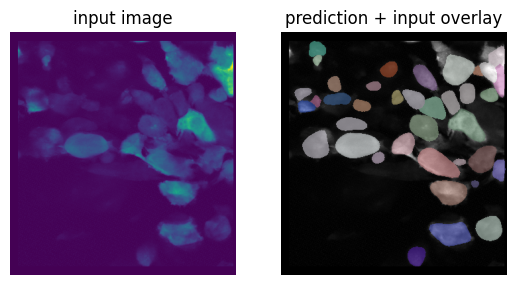

In [18]:
display_stardist(image_at_time[1], all_stardist['fluo'])

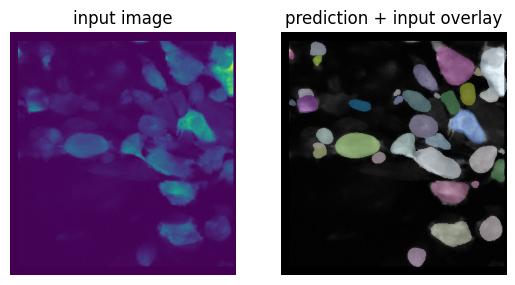

In [19]:
display_stardist(image_at_time[1], all_stardist['dsb'])

### H&E model

Of course, the H&E model requires an RGB image and thus can't be applied to the same image as we see above.

Thus we'll display a different image and its results

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


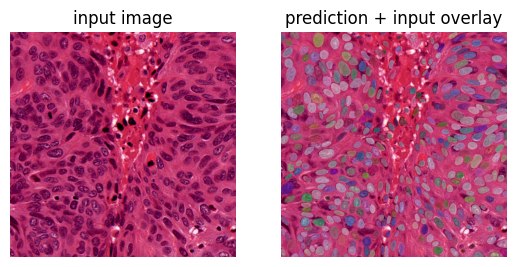

In [20]:
he_img = tifffile.imread("TCGA-18-5592-01Z-00-DX1.tif")
display_stardist(he_img, all_stardist['he'])